In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf


from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn import ensemble, neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plt.rcParams.update({'font.size': 30})
%matplotlib inline

# Background 

Using a dataset taken from kaggle, I will create a model to predict a house's value. I want to be able to understand what creates value in a house and use different models to see which will be the strongest predictor. The dataset can be found here: https://www.kaggle.com/anthonypino/melbourne-housing-market

In [2]:
housing_data = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
housing_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
# Right away, we can see that there is missing data, let's check how much data there is.
housing_data.shape

(34857, 21)

In [5]:
# Look at the different columns and their data type.
housing_data.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

## Explaining what each column means.

Some Key Details

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

In [6]:
# Remove the NAN so that I can manipulate the dataset. 
housing_data = housing_data.dropna()

In [7]:
# Check for outliers..
# Notice that there are now 8887 rows instead of the original 34,867.
housing_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,3111.662653,3.078204,1.646450,1.692247,523.480365,149.309477,1965.753348,-37.804501,144.991393,7475.940137
std,0.963786,6.793819e+05,6.813402,112.614268,0.966269,0.721611,0.975464,1061.324228,87.925580,37.040876,0.090549,0.118919,4375.024364
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.174360,144.423790,249.000000
25%,2.000000,6.410000e+05,6.400000,3044.000000,2.000000,1.000000,1.000000,212.000000,100.000000,1945.000000,-37.858560,144.920000,4382.500000
50%,3.000000,9.000000e+05,10.200000,3084.000000,3.000000,2.000000,2.000000,478.000000,132.000000,1970.000000,-37.798700,144.998500,6567.000000
75%,4.000000,1.345000e+06,13.900000,3150.000000,4.000000,2.000000,2.000000,652.000000,180.000000,2000.000000,-37.748945,145.064560,10331.000000
max,12.000000,9.000000e+06,47.400000,3977.000000,12.000000,9.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.526350,21650.000000


In [8]:
# There are a lot of string type variables. 
# Convert some of the data into continuous variables first.
list(housing_data['Regionname'].unique())


['Northern Metropolitan',
 'Western Metropolitan',
 'Southern Metropolitan',
 'Eastern Metropolitan',
 'South-Eastern Metropolitan',
 'Northern Victoria',
 'Eastern Victoria',
 'Western Victoria']

In [28]:
# Map numbers to Regionname.
housing_data['Num_region'] = housing_data['Regionname'].map(
    {'Northern Metropolitan':1,'Western Metropolitan':2,'Southern Metropolitan':3,'Eastern Metropolitan':4,
     'South-Eastern Metropolitan':5,'Northern Victoria':6,'Eastern Victoria':7,'Western Victoria':8})

In [26]:
# Show that there are only 3 unique values in 'Type
list(housing_data['Type'].unique())

# Create a new column for Type so I can use the data later 
housing_data['Num_type'] = housing_data['Type'].map({'h':1, 'u':2, 't':3})

In [29]:
list(housing_data['Method'].unique())

['S', 'SP', 'VB', 'PI', 'SA']

In [30]:
# Create a numeroical method column 
housing_data['Num_method'] = housing_data['Method'].map({
    'S':1, 'SP':2, 'VB':3, 'PI':4, 'SA':5})

In [61]:
# Drop data that I cannot use, namely the string type data.
drop_list = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 
             'CouncilArea', 'Regionname', 'Postcode']

# Create a new data subset. 
# hd means housing data.
Modded_hd = housing_data.drop(drop_list, 1)

In [62]:
Modded_hd.head()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Num_region,Num_type,Num_method
2,2,1035000.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,1,1,1
4,3,1465000.0,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0,1,1,2
6,4,1600000.0,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0,1,1,3
11,3,1876000.0,2.5,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0,1,1,1
14,2,1636000.0,2.5,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0,1,1,1


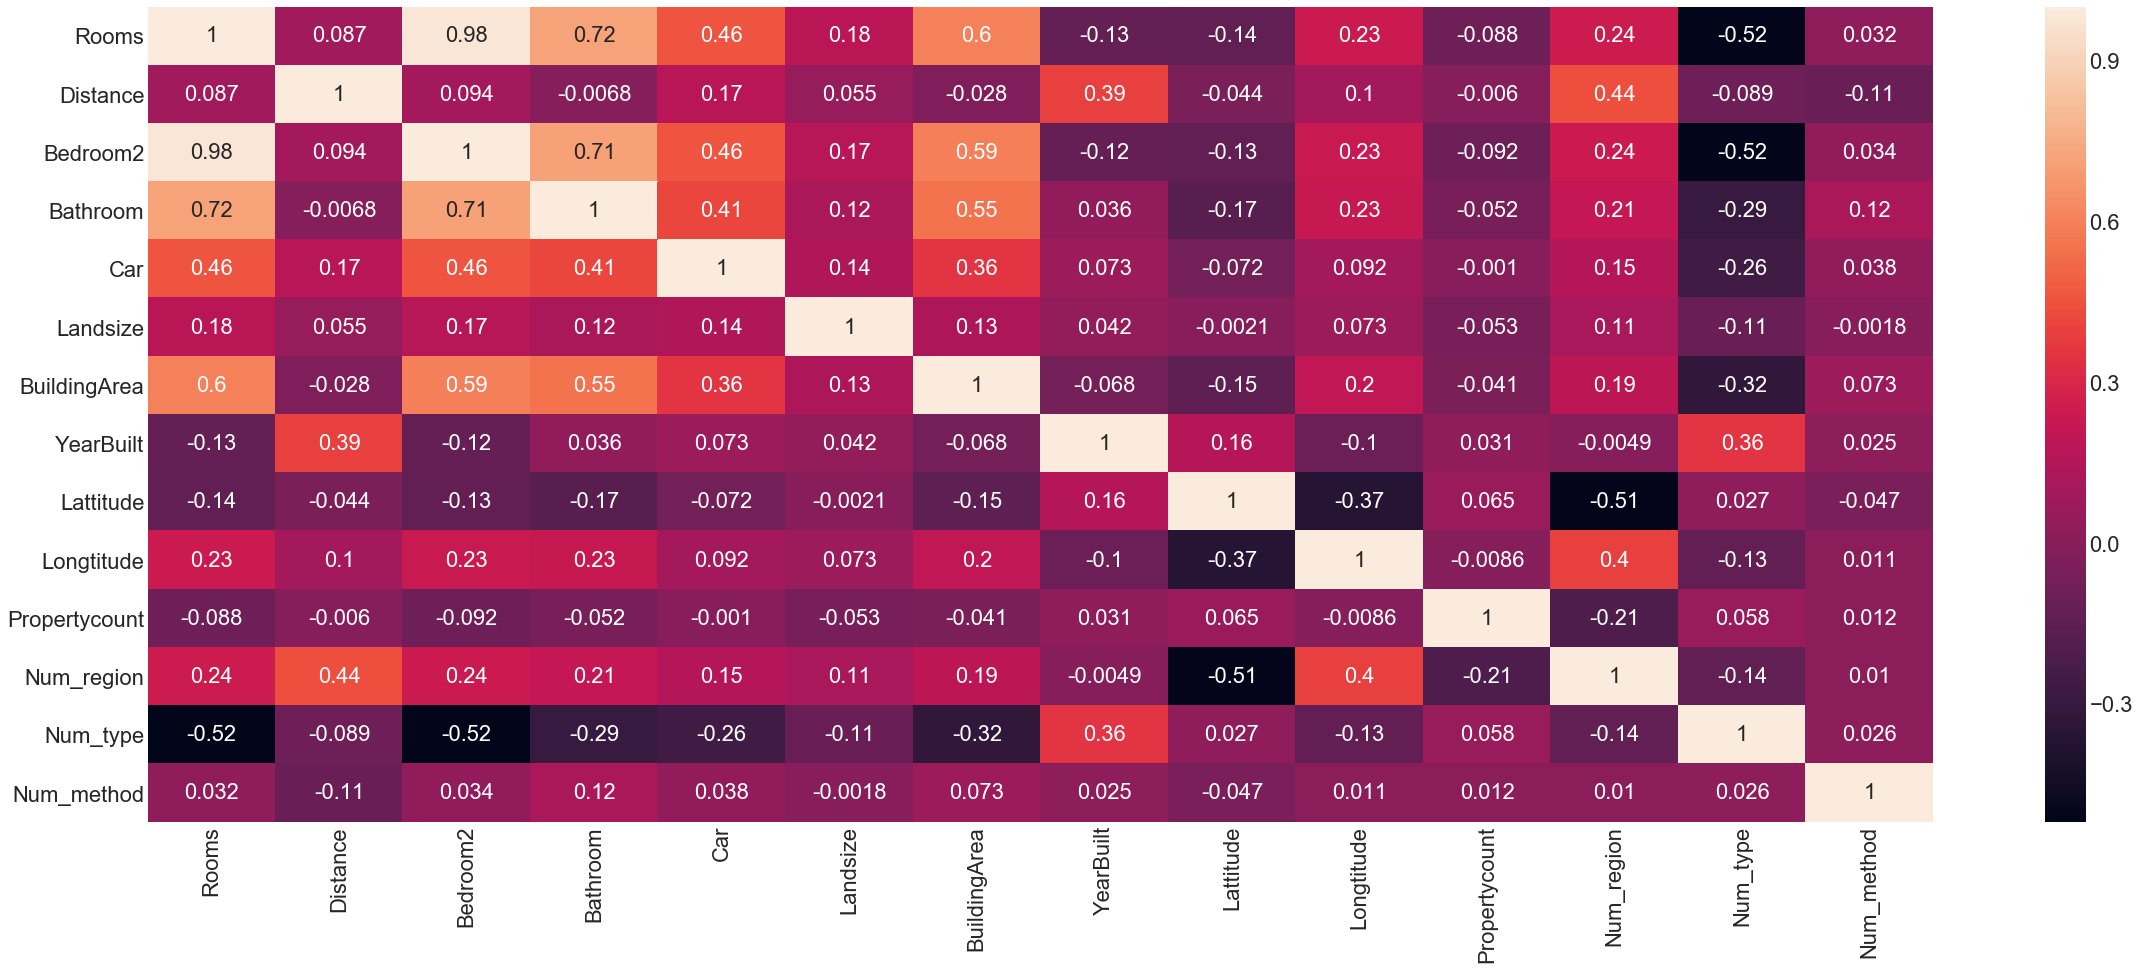

In [63]:
# Lets use a heatmap next to see if there are any correlations first. 
housing_price = Modded_hd.groupby('Price').mean()

plt.figure(figsize=(40,15))
plt.rcParams.update({'font.size': 22})
sns.heatmap(data=housing_price.corr(), annot=True);

# Model 1: Linear Regression with Ridge Regression

4 Assumptions before I can use the Linear Regression:
 - Assume linear relationship
 - multivariate normality
 - homoskedasticity
 - low multicollinearity
 
The first one and the the fourth one are ready. I will prepare to achieve normality and homoskedasticity.

In [184]:
# None of the variables suffer from high multicollinearity.
# Try to figure out what are the most important features first. 
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression 

# Set my variables.
skb_X = Modded_hd.drop('Price', 1)
skb_y = Modded_hd['Price']

# fit SelectKBest
housing_skb = SelectKBest(score_func=feature_selection.f_regression).fit(skb_X,skb_y)

# Identify features with highest score from a predictive perspective (for all programs) 
names = skb_X.columns
best_features = pd.DataFrame(housing_skb.scores_, index = names) 
best_features.columns = ['Best Features'] 
best_features.sort_values(by=['Best Features'], ascending=True)

# Take a look at what the best features are.
print(best_features)

               Best Features
Rooms            2354.315459
Distance          253.132343
Bedroom2         2239.366496
Bathroom         1604.174351
Car               301.703016
Landsize         1034.968117
BuildingArea     3325.073046
YearBuilt         912.666823
Lattitude         773.769393
Longtitude        538.721258
Propertycount    2354.315459
Num_region        518.851683
Num_type          830.456188
Num_method         13.466982


In [66]:
# Look at what outliers I can remove. 
Modded_hd.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Num_region,Num_type,Num_method
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,3.078204,1.646450,1.692247,523.480365,149.309477,1965.753348,-37.804501,144.991393,7475.940137,2.442557,1.335771,1.730055
std,0.963786,6.793819e+05,6.813402,0.966269,0.721611,0.975464,1061.324228,87.925580,37.040876,0.090549,0.118919,4375.024364,1.284459,0.620932,1.097508
min,1.000000,1.310000e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.174360,144.423790,249.000000,1.000000,1.000000,1.000000
25%,2.000000,6.410000e+05,6.400000,2.000000,1.000000,1.000000,212.000000,100.000000,1945.000000,-37.858560,144.920000,4382.500000,1.000000,1.000000,1.000000
50%,3.000000,9.000000e+05,10.200000,3.000000,2.000000,2.000000,478.000000,132.000000,1970.000000,-37.798700,144.998500,6567.000000,2.000000,1.000000,1.000000
75%,4.000000,1.345000e+06,13.900000,4.000000,2.000000,2.000000,652.000000,180.000000,2000.000000,-37.748945,145.064560,10331.000000,3.000000,2.000000,2.000000
max,12.000000,9.000000e+06,47.400000,12.000000,9.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.526350,21650.000000,8.000000,3.000000,5.000000


In [107]:
# I'm greedy so I want to keep all of the features for my regression.
Modded_hd = Modded_hd[(Modded_hd['Rooms'] <8) & (Modded_hd['Price']<3000000)
                     & (Modded_hd['Distance']<21) & (Modded_hd['Bathroom']<5)
                     & (Modded_hd['Bedroom2']<8) & (Modded_hd['Car']<5)
                     & (Modded_hd['Landsize']<1000) & (Modded_hd['BuildingArea']<500)
                     & (Modded_hd['Propertycount']<12000)]

In [108]:
Modded_hd.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Num_region,Num_type,Num_method
count,6644.000000,6.644000e+03,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000,6644.000000
mean,3.061108,1.085494e+06,9.827830,3.038380,1.609723,1.609121,404.892836,143.399193,1963.273931,-37.801122,144.987034,3.061108,2.312312,1.357917,1.732691
std,0.920209,5.390921e+05,4.395728,0.919065,0.670558,0.838618,256.781013,66.677497,36.672387,0.073374,0.094380,0.920209,1.046773,0.647936,1.100905
min,1.000000,1.310000e+05,0.700000,0.000000,1.000000,0.000000,0.000000,0.000000,1850.000000,-37.990400,144.654070,1.000000,1.000000,1.000000,1.000000
25%,2.000000,6.810000e+05,6.400000,2.000000,1.000000,1.000000,192.000000,100.000000,1940.000000,-37.851852,144.913982,2.000000,1.000000,1.000000,1.000000
50%,3.000000,9.500000e+05,9.400000,3.000000,2.000000,2.000000,407.000000,130.000000,1970.000000,-37.793975,144.992070,3.000000,2.000000,1.000000,1.000000
75%,4.000000,1.375000e+06,13.000000,4.000000,2.000000,2.000000,615.000000,176.000000,1998.000000,-37.753065,145.057092,4.000000,3.000000,2.000000,2.000000
max,7.000000,2.990000e+06,20.800000,7.000000,4.000000,4.000000,999.000000,495.000000,2019.000000,-37.534460,145.248390,7.000000,5.000000,3.000000,5.000000


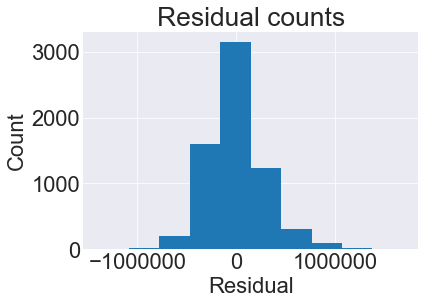

In [122]:
# Set up variables.
X = Modded_hd.drop('Price', 1)
y = Modded_hd['Price'].values.reshape(-1, 1)


# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X,y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Modded_hd['Price']

# Calculate the error, aka residual.
residual = actual - predicted


sns.set_style('darkgrid')
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

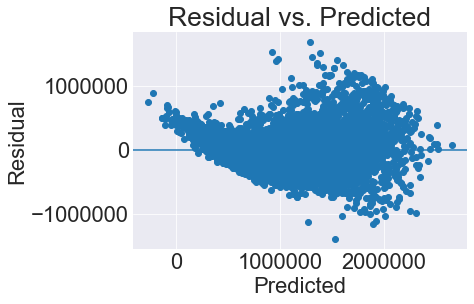

In [123]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [159]:
# It looks closer to a normal distribution and it's sort of homoscedastic
# Instantiate and fit our model.
regr = linear_model.LinearRegression()

# Set up variables.
skb_X = Modded_hd.drop('Price', 1)
skb_y = Modded_hd['Price'].values.reshape(-1, 1)

#Fit the model.
regr.fit(skb_X, skb_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [189]:
# Instantiate SelectKBest
kbest = SelectKBest(f_regression)

# Instantiate pipeline
pipeline = Pipeline([('kbest', kbest), ('regr', linear_model.LinearRegression())])

# Set up parameters
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14]})

#Fit the model
grid_search.fit(skb_X, skb_y)

# Return best parameters and best score
print('Best parameters:')
print(grid_search.best_params_)
print('Best Score:')
print(grid_search.best_score_)

Best parameters:
{'kbest__k': 14}
Best Score:
0.6920504965489139


In [ ]:
# # It looks closer to a normal distribution and it's sort of homoscedastic
# # Instantiate and fit our model.
# ridge_regressor = Ridge()

# # Set up variables.
# skb_X = Modded_hd.drop('Price', 1)
# skb_y = Modded_hd['Price'].values.reshape(-1, 1)

# # Create ridge parameters for GS-CV
# param_grid = {'alpha':[.000001, .00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}

# # Set up GS-CV
# grid = GridSearchCV(Ridge, param_grid, cv=5, verbose=2, n_jobs=-1)

# #Fit the grid.
# grid.fit(skb_X, skb_y)
# #

In [124]:
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(skb_X, skb_y))


Coefficients: 
 [[ 2.20593078e+04 -4.70477889e+04  5.11357811e+04  1.16642163e+05
   2.86146399e+04  3.75772161e+02  2.68486987e+03 -3.05920861e+03
  -1.75203423e+06  1.03547689e+06  2.20593078e+04  1.30260304e+03
  -5.96862384e+04 -1.94651725e+04]]

Intercept: 
 [-2.09755265e+08]

R-squared:
0.7084208839534512


In [127]:
# Check for overfitting.
cross_val_score(regr, skb_X, skb_y, cv=5)

array([0.71082633, 0.73786979, 0.70534565, 0.67888345, 0.65146544])

In [132]:
# Already ran a cross validation on my initial model.
#  Find the p value 
linear_formula = 'Price ~ Rooms+Price+Distance+Bedroom2+Bathroom+Car+Landsize+BuildingArea+YearBuilt+Lattitude+Longtitude+Propertycount+Num_region+Num_type+Num_method'

# Fit the model to our data using the formula. 
lm = smf.ols(formula=linear_formula, data=Modded_hd).fit()
# Model one results are
print(lm.params)

Intercept       -5.215406e-08
Rooms            6.075425e-10
Price            1.000000e+00
Distance         2.228262e-11
Bedroom2         1.527951e-10
Bathroom         2.546585e-11
Car              7.639755e-11
Landsize        -1.207923e-13
BuildingArea    -6.536993e-13
YearBuilt       -1.364242e-12
Lattitude        1.818989e-10
Longtitude       6.693881e-10
Propertycount    6.639311e-10
Num_region       5.047696e-11
Num_type        -8.185452e-12
Num_method       8.185452e-12
dtype: float64


In [133]:
print(lm.pvalues)

Intercept        0.961298
Rooms            0.561311
Price            0.000000
Distance         0.896844
Bedroom2         0.940579
Bathroom         0.981670
Car              0.914188
Landsize         0.968014
BuildingArea     0.959121
YearBuilt        0.942951
Lattitude        0.984737
Longtitude       0.921242
Propertycount    0.525553
Num_region       0.943529
Num_type         0.993672
Num_method       0.985942
dtype: float64
1.0


# Analysis

The linear regression model is a strong predictor as long as the four conditions are fulfilled that I mentioned above. Due to the fact that I wasn't super strict on the conditions, it's predicting capabilities were a bit lower since it can be influenced by the existence of outliers in the features columns. Lastly, this model was overfitted due to the amount of data inputted, but this could be remedied if I were able to implement the ridge regression correctly. 

# Model 2: KNN Regression 


In [196]:
from sklearn.neighbors import KNeighborsRegressor

# Initiate the model.
knr = KNeighborsRegressor()

# Instantiate pipeline
knr_pipeline = Pipeline([('kbest', kbest), ('knr', KNeighborsRegressor())])

knr_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                                     'knr__n_neighbors':[2,4,5,7,9,10,20,40,50,75,100]}

# Set up parameters
knr_grid = GridSearchCV(knr_pipeline, knr_params, cv=5, verbose=1, n_jobs=-1)

# Set up the variables.
X = Modded_hd.drop('Price', 1)
y = Modded_hd['Price'].values.reshape(-1, 1)

# Search for the best paramters. 
# knr_grid = GridSearchCV(knr, params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knr_grid.fit(X, y)

# Return best parameters and best score
print('Best parameters:')
print(knr_grid.best_params_)
print('Best Score:')
print(knr_grid.best_score_)

Fitting 5 folds for each of 154 candidates, totalling 770 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.3s


Best parameters:
{'kbest__k': 14, 'knr__n_neighbors': 20}
Best Score:
0.5500670260397578


[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:   11.0s finished


In [198]:
# Implement the parameters.
knr = KNeighborsRegressor(n_neighbors=20, weights='distance')

# Cross Validate the knn model. 
cross_val_score(knr, X, y, cv=5)

array([0.59614759, 0.61254575, 0.57278026, 0.54944793, 0.47209068])

# Analysis

# Model 3: Decision Tree Regressor

In [203]:
from sklearn.tree import DecisionTreeRegressor

#Instantiate the model.
dtr = DecisionTreeRegressor()

# Instantiate pipeline
dtr_pipeline = Pipeline([('kbest', kbest), ('dtr', DecisionTreeRegressor())])

dtr_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                          'dtr__max_depth':[2,4,6]}

# Set up parameters
dtr_grid = GridSearchCV(dtr_pipeline, dtr_params, cv=5, verbose=1, n_jobs=-1)


# Fit the grid and obtain results
dtr_grid.fit(X, y)

# Return best parameters and best score
print('Best parameters:')
print(dtr_grid.best_params_)
print('Best Score:')
print(dtr_grid.best_score_)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters:
{'dtr__max_depth': 6, 'kbest__k': 13}
Best Score:
0.6882593613847188


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.6s finished


In [207]:
# Cross Validate the dtr model. 
cross_val_score(dtr_grid, X, y, cv=5)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.6s finished


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.7s finished


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.7s finished


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.6s finished


array([0.64482514, 0.70011877, 0.67949126, 0.72434876, 0.67058784])

# Analysis

# Model 4: SVM Regression

In [210]:
from sklearn import svm

#Instantiate model
svr = svm.SVR()

# Instantiate pipeline
svr_pipeline = Pipeline([('kbest', kbest), ('svr', svm.SVR())])

svr_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                          'svr__C':[.00001,.0001,.001,.01,.1,1,
                    10,100,1000,10000]}

# Set up parameters
svr_grid = GridSearchCV(svr_pipeline, svr_params, cv=5, verbose=1, n_jobs=-1)


# Fit the grid and obtain results
svr_grid.fit(X, y)

# Return best parameters and best score
print('Best parameters:')
print(svr_grid.best_params_)
print('Best Score:')
print(svr_grid.best_score_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  4.0min finished


Best parameters:
{'kbest__k': 5, 'svr__C': 10000}
Best Score:
0.1453976601153223


In [215]:
# Cross Validate the svr model. 
cross_val_score(svr_grid, X, y, cv=5)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.6min finished


Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.5min finished


Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.4min finished


Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.4min finished


Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  2.4min finished


array([ 0.12402251,  0.21420774,  0.22500242,  0.16911176, -0.00546965])

# Analysis


# Model 5: Gradient Boosted Model 

In [218]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor()

# Instantiate pipeline
clf_pipeline = Pipeline([('kbest', kbest), ('clf', ensemble.GradientBoostingRegressor())])

clf_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                          'clf__n_estimators': [100,200,500,800,1000],
             'clf__max_depth': [2,4,6]}

# Set up parameters
clf_grid = GridSearchCV(clf_pipeline, clf_params, cv=5, verbose=1, n_jobs=-1)


# Fit the grid and obtain results
clf_grid.fit(X, y)

# Return best parameters and best score
print('Best parameters:')
print(clf_grid.best_params_)
print('Best Score:')
print(clf_grid.best_score_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  5.7min finished


Best parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200, 'kbest__k': 14}
Best Score:
0.8376722922698951


In [221]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=6)

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X, y, cv=5)

array([0.82516691, 0.82741528, 0.84160156, 0.85354946, 0.84096313])

# Analysis

# Model 6: Random Forest Regression

In [227]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the random forest model.
rfr = RandomForestRegressor()

# Instantiate pipeline
rfr_pipeline = Pipeline([('kbest', kbest), ('rfr', RandomForestRegressor())])

rfr_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                          'rfr__n_estimators': [10,50,100,200,500,1000],
             'rfr__max_depth': [2,4,6]}

# Set up parameters
rfr_grid = GridSearchCV(rfr_pipeline, rfr_params, cv=5, verbose=1, n_jobs=-2)

# Set up the variables.
X = Modded_hd.drop('Price', 1)
y = Modded_hd['Price'].values.reshape(-1, 1)

# Fit the grid and obtain results
rfr_grid.fit(X, y)

# Return best parameters and best score
print('Best parameters:')
print(rfr_grid.best_params_)
print('Best Score:')
print(rfr_grid.best_score_)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-2)]: Done 299 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-2)]: Done 549 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 899 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 1260 out of 1260 | elapsed:  6.2min finished


Best parameters:
{'kbest__k': 14, 'rfr__max_depth': 6, 'rfr__n_estimators': 1000}
Best Score:
0.7538135316246616


In [228]:
# Instantiate the random forest model.
rfr = RandomForestRegressor(n_estimators=1000, max_depth=6, max_features='auto')

# Cross Validate the gradient boosting model. 
cross_val_score(rfr, X, y, cv=5)

array([0.72773831, 0.7497098 , 0.7559888 , 0.78421463, 0.74964735])

# Write Up 

# Repeating all the models, but with PCA instead. 